<a href="https://colab.research.google.com/github/abaysoy/Learning/blob/main/1_SnapATAC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code written by Yao Lu, annotated by Shuozhen Bao

## Install the package
If there's a error message about the pip dependency resolver, this is due to the CoLab default environment. As long as the packages are installed successfully, it's okay to proceed.

In [1]:
!pip install anndata==0.8.0 snapatac2==2.4.0 scanpy==1.9.3 scipy pandas==1.5.3 numpy==1.24.3

In [2]:
## If you are using the files on your local computer, no need to run this chunk
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import snapatac2 as snap
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
from scipy import sparse

## Import the raw data
Take a look at the data structure, change the input and output directory path to your own.

In [4]:
dir_in = '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/01.demo_data'
dir_out = '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/03.output'
## see the normalized peak matrix from human data
adata_atac = sc.read_h5ad(dir_in+'/Human_hippocampus/adata_peaks_normalized.h5ad')

In [5]:
adata_atac

AnnData object with n_obs × n_vars = 9215 × 121068
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_peaks', 'nFeature_peaks', 'RNA_clusters', 'ATAC_clusters'
    var: 'count', 'percentile'
    uns: 'ATAC', 'ATAC_clusters_colors', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap', 'spatial'
    obsp: 'ATAC_connectivities', 'ATAC_distances'

In [6]:
adata_atac.var_names

Index(['chr1-3094734-3095650', 'chr1-3119757-3120179', 'chr1-3120267-3120653',
       'chr1-3121314-3122051', 'chr1-3264998-3265766', 'chr1-3292462-3293293',
       'chr1-3294044-3295081', 'chr1-3300717-3301474', 'chr1-3301682-3302319',
       'chr1-3309769-3310662',
       ...
       'JH584304.1-106380-107258', 'JH584304.1-112856-113752',
       'GL456216.1-13410-14374', 'GL456216.1-16007-16700',
       'GL456216.1-16825-17441', 'GL456216.1-31908-32576',
       'GL456216.1-43983-44510', 'GL456216.1-48771-49683',
       'JH584292.1-12571-13497', 'JH584295.1-1163-1976'],
      dtype='object', length=121068)

## Process fragment file from ATAC into snapATAC2

In [7]:
snap.__version__

'2.4.0'

In [8]:
ad.__version__

'0.8.0'

In [9]:
fragment_file = dir_in + '/Human_hippocampus/fragments.tsv.gz'

In [10]:
%%time
#colab 5 min
data = snap.pp.import_data(
    fragment_file,
    genome=snap.genome.hg38,
    file = dir_in + "/human_hippo_atac.h5ad",
    sorted_by_barcode=False,
)
data

CPU times: user 5min 43s, sys: 19 s, total: 6min 2s
Wall time: 6min 30s


AnnData object with n_obs x n_vars = 2500 x 0 backed at '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/01.demo_data/human_hippo_atac.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

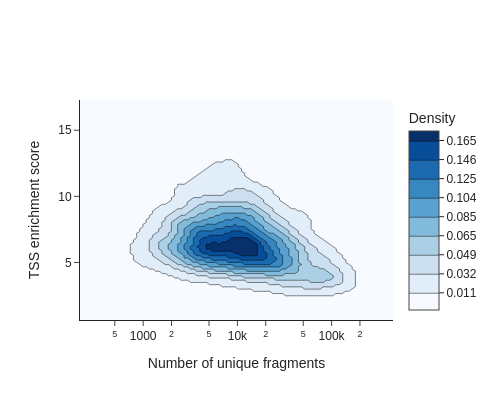

In [11]:
snap.pl.tsse(data, interactive=False)

In [12]:
%%time
#colab 1min 12s
snap.pp.add_tile_matrix(data)

CPU times: user 1min 12s, sys: 8.57 s, total: 1min 20s
Wall time: 1min 24s


In [13]:
data

AnnData object with n_obs x n_vars = 2500 x 6062095 backed at '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/01.demo_data/human_hippo_atac.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'insertion'

In [14]:
snap.pp.select_features(data, n_features=250000)

## Dimenstion reduction

In [15]:
%%time
#colab 53.5s
snap.tl.spectral(data)

CPU times: user 31.8 s, sys: 3.21 s, total: 35 s
Wall time: 35.9 s


In [17]:
%%time
snap.tl.umap(data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



CPU times: user 1min 17s, sys: 9.96 s, total: 1min 27s
Wall time: 1min 19s


## Clustering and call peaks

In [18]:
%%time
snap.pp.knn(data)
snap.tl.leiden(data)

CPU times: user 1.6 s, sys: 94.7 ms, total: 1.69 s
Wall time: 1.28 s


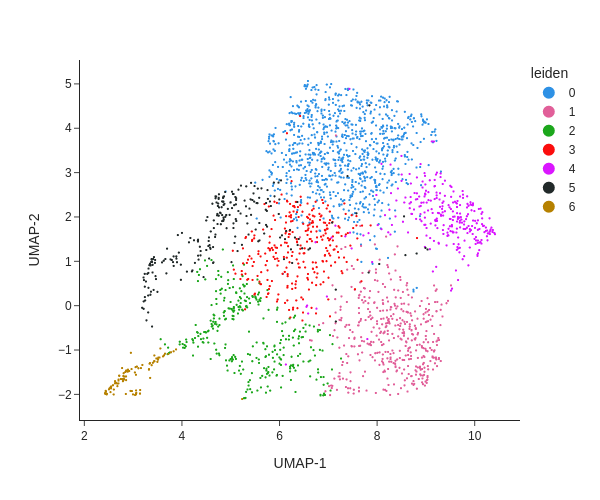

In [19]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

In [20]:
%%time
# colab time 3min 54s
snap.tl.call_peaks(data, groupby='leiden')

CPU times: user 3min 43s, sys: 18.2 s, total: 4min 1s
Wall time: 14min 26s


In [21]:
data

AnnData object with n_obs x n_vars = 2500 x 6062095 backed at '/content/drive/My Drive/ATAC_RNA_Analysis_Workshop/01.demo_data/human_hippo_atac.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'spectral_eigenvalue', 'peaks'
    obsm: 'X_spectral', 'insertion', 'X_umap'
    obsp: 'distances'

In [22]:
%%time
peak_mat = snap.pp.make_peak_matrix(data)
peak_mat

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



CPU times: user 1min 36s, sys: 3.95 s, total: 1min 40s
Wall time: 1min 15s


AnnData object with n_obs × n_vars = 2500 × 306104
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'leiden'

In [23]:
sc.pp.normalize_total(peak_mat)
sc.pp.log1p(peak_mat)

In [24]:
peak_mat

AnnData object with n_obs × n_vars = 2500 × 306104
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'leiden'
    uns: 'log1p'

In [ ]:
peak_mat.write(dir_out+'/human_hippo_peak_mat.h5ad')

## Import DBiT RNA data

In [25]:
data_folder = dir_in + '/Human_hippocampus'
exp_mtx_path = f'{data_folder}/brain_E_stdata_names.tsv'
exp_mtx = pd.read_csv(f'{data_folder}/brain_E_stdata_names.tsv', delimiter='\t', index_col=0)

In [37]:
barcodes_list = pd.read_csv(f'{data_folder}/spatial_barcodes.txt', delimiter='\t', header=None)

In [38]:
barcodes_list['index'] = barcodes_list[[1,2]].astype('str').agg('x'.join, axis=1)

In [39]:
obs_barcodes = [barcodes_list[barcodes_list['index']== item][0].tolist()[0]+'-1' for item in list(exp_mtx.index)]

In [40]:
len(obs_barcodes)

2500

In [41]:
adata_rna = ad.AnnData(sparse.csc_matrix(exp_mtx.values))
adata_rna.obs_names = obs_barcodes
adata_rna.var_names = list(exp_mtx.columns)

<ipython-input-41-868172ce7ac2>:1: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [42]:
adata_rna.obs_names_make_unique()

In [43]:
adata_rna.obs_names

Index(['CCGTGAGAAGAGTCAA-1', 'AGATCGCAGAATCTGA-1', 'CGACTGGAAAGACGGA-1',
       'ATCCTGTACCGTGAGA-1', 'AGAGTCAAACGTATCA-1', 'AGTGGTCAGAATCTGA-1',
       'CATACCAAAACGCTTA-1', 'ACAGCAGAAAGGTACA-1', 'CTGTAGCCACTATGCA-1',
       'CTGGCATAAGCAGGAA-1',
       ...
       'AAGGTACAACCACTGT-1', 'CTGTAGCCAACGTGAT-1', 'GACTAGTAAAACATCG-1',
       'ACGCTCGAAAACATCG-1', 'ACGTATCACCGTGAGA-1', 'CAGCGTTAAGTGGTCA-1',
       'ACAAGCTAAGTGGTCA-1', 'ACTATGCAAAACATCG-1', 'ACGTATCAAACGTGAT-1',
       'ACGTATCAAAACATCG-1'],
      dtype='object', length=2500)

In [44]:
obs_match = 0
for item in adata_rna.obs_names:
    if item in peak_mat.obs_names:
        obs_match +=1

In [45]:
obs_match

2500

In [46]:
adata_rna

AnnData object with n_obs × n_vars = 2500 × 37071

In [ ]:
adata_rna.write(dir_out + '/human_hippo_rna_mat.h5ad')